### Importing Necessary Datasets

In [1]:
import pandas as pd
import datetime
import numpy as np
import json
import pymongo
import matplotlib.pyplot as plt
import seaborn as sns
from math import radians

from sklearn import svm
from sklearn.ensemble  import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
from xgboost import XGBClassifier

### Importing Data

https://www.kaggle.com/c/new-york-city-taxi-fare-prediction/data?select=train.csv

In [2]:
df = pd.read_csv('taxifare.csv')
df.head()

,pickup_datetime,fare_amount,fare_class,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2010-04-19 08:17:56 UTC,6.5,0,-73.992365,40.730521,-73.975499,40.744746,1
1,2010-04-17 15:43:53 UTC,6.9,0,-73.990078,40.740558,-73.974232,40.744114,1
2,2010-04-17 11:23:26 UTC,10.1,1,-73.994149,40.751118,-73.960064,40.766235,2
3,2010-04-11 21:25:03 UTC,8.9,0,-73.990485,40.756422,-73.971205,40.748192,1
4,2010-04-17 02:19:01 UTC,19.7,1,-73.990976,40.734202,-73.905956,40.743115,1


In [3]:
df.shape

(120000, 8)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120000 entries, 0 to 119999
Data columns (total 8 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   pickup_datetime    120000 non-null  object 
 1   fare_amount        120000 non-null  float64
 2   fare_class         120000 non-null  int64  
 3   pickup_longitude   120000 non-null  float64
 4   pickup_latitude    120000 non-null  float64
 5   dropoff_longitude  120000 non-null  float64
 6   dropoff_latitude   120000 non-null  float64
 7   passenger_count    120000 non-null  int64  
dtypes: float64(5), int64(2), object(1)
memory usage: 7.3+ MB


### Feature Engineering

##### Converting pickup datettime field to date time format from object format

In [5]:
pd.to_datetime(df['pickup_datetime'])

0        2010-04-19 08:17:56+00:00
1        2010-04-17 15:43:53+00:00
2        2010-04-17 11:23:26+00:00
3        2010-04-11 21:25:03+00:00
4        2010-04-17 02:19:01+00:00
                    ...           
119995   2010-04-18 14:33:03+00:00
119996   2010-04-23 10:27:48+00:00
119997   2010-04-18 18:50:40+00:00
119998   2010-04-13 08:14:44+00:00
119999   2010-04-17 16:00:14+00:00
Name: pickup_datetime, Length: 120000, dtype: datetime64[ns, UTC]

##### Since datatime is in UTC time, we are turning it to EST

In [6]:
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])-datetime.timedelta(hours=4)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120000 entries, 0 to 119999
Data columns (total 8 columns):
 #   Column             Non-Null Count   Dtype              
---  ------             --------------   -----              
 0   pickup_datetime    120000 non-null  datetime64[ns, UTC]
 1   fare_amount        120000 non-null  float64            
 2   fare_class         120000 non-null  int64              
 3   pickup_longitude   120000 non-null  float64            
 4   pickup_latitude    120000 non-null  float64            
 5   dropoff_longitude  120000 non-null  float64            
 6   dropoff_latitude   120000 non-null  float64            
 7   passenger_count    120000 non-null  int64              
dtypes: datetime64[ns, UTC](1), float64(5), int64(2)
memory usage: 7.3 MB


##### Breaking pickup_datetime field into Year, Month, Day, Hours and Minutes

In [8]:
df['Year'] = df['pickup_datetime'].dt.year
df['Month'] = df['pickup_datetime'].dt.month
df['Day'] = df['pickup_datetime'].dt.day
df['Hours'] = df['pickup_datetime'].dt.hour
df['Minutes'] = df['pickup_datetime'].dt.minute

In [9]:
df.head()

,pickup_datetime,fare_amount,fare_class,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,Year,Month,Day,Hours,Minutes
0,2010-04-19 04:17:56+00:00,6.5,0,-73.992365,40.730521,-73.975499,40.744746,1,2010,4,19,4,17
1,2010-04-17 11:43:53+00:00,6.9,0,-73.990078,40.740558,-73.974232,40.744114,1,2010,4,17,11,43
2,2010-04-17 07:23:26+00:00,10.1,1,-73.994149,40.751118,-73.960064,40.766235,2,2010,4,17,7,23
3,2010-04-11 17:25:03+00:00,8.9,0,-73.990485,40.756422,-73.971205,40.748192,1,2010,4,11,17,25
4,2010-04-16 22:19:01+00:00,19.7,1,-73.990976,40.734202,-73.905956,40.743115,1,2010,4,16,22,19


##### Classifying Morning Night

In [10]:
df['MorningNight']=np.where(df['Hours']<12,0,1)

In [11]:
df.drop('pickup_datetime',axis=1,inplace=True)

In [12]:
df.head()

,fare_amount,fare_class,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,Year,Month,Day,Hours,Minutes,MorningNight
0,6.5,0,-73.992365,40.730521,-73.975499,40.744746,1,2010,4,19,4,17,0
1,6.9,0,-73.990078,40.740558,-73.974232,40.744114,1,2010,4,17,11,43,0
2,10.1,1,-73.994149,40.751118,-73.960064,40.766235,2,2010,4,17,7,23,0
3,8.9,0,-73.990485,40.756422,-73.971205,40.748192,1,2010,4,11,17,25,1
4,19.7,1,-73.990976,40.734202,-73.905956,40.743115,1,2010,4,16,22,19,1


##### Calculating Haversine Distances using Latitude and Longitude values

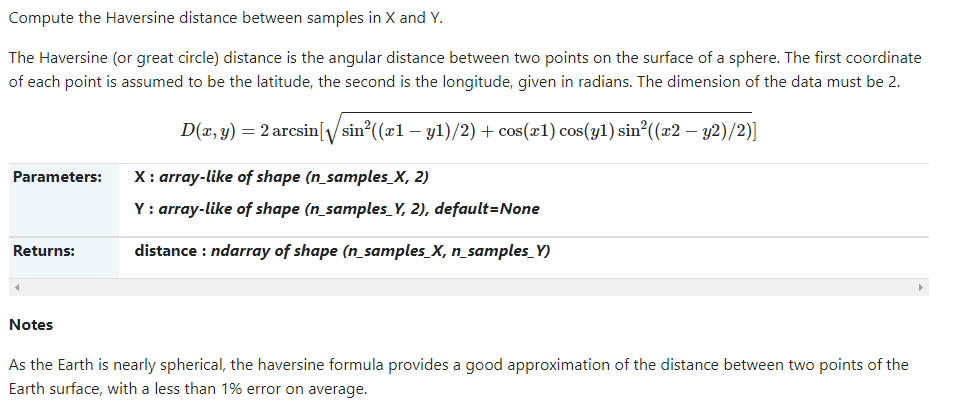

In [13]:
def haversine(df):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    lat1= np.radians(df["pickup_latitude"])
    lat2 = np.radians(df["dropoff_latitude"])
    #### Based on the formula  x1=drop_lat,x2=dropoff_long 
    dlat = np.radians(df['dropoff_latitude']-df["pickup_latitude"])
    dlong = np.radians(df["dropoff_longitude"]-df["pickup_longitude"])
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlong/2)**2

    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    r = 6371 # Radius of earth in kilometers. Use 3956 for miles
    return c * r

In [14]:
df['Total_Distance'] = haversine(df)

In [15]:
df.drop(["pickup_longitude","pickup_latitude","dropoff_longitude","dropoff_latitude"],axis=1,inplace=True)

In [16]:
df.head()

,fare_amount,fare_class,passenger_count,Year,Month,Day,Hours,Minutes,MorningNight,Total_Distance
0,6.5,0,1,2010,4,19,4,17,0,2.126312
1,6.9,0,1,2010,4,17,11,43,0,1.392307
2,10.1,1,2,2010,4,17,7,23,0,3.326763
3,8.9,0,1,2010,4,11,17,25,1,1.864129
4,19.7,1,1,2010,4,16,22,19,1,7.231321


### Classification Model Creation

#### Exporting Data to CSV

In [17]:
X=df.iloc[:,[0,2,3,4,5,6,7,8,9]]
y=df.iloc[:,1]
X.head()

,fare_amount,passenger_count,Year,Month,Day,Hours,Minutes,MorningNight,Total_Distance
0,6.5,1,2010,4,19,4,17,0,2.126312
1,6.9,1,2010,4,17,11,43,0,1.392307
2,10.1,2,2010,4,17,7,23,0,3.326763
3,8.9,1,2010,4,11,17,25,1,1.864129
4,19.7,1,2010,4,16,22,19,1,7.231321


In [18]:
y.head()

0    0
1    0
2    1
3    0
4    1
Name: fare_class, dtype: int64

In [19]:
df.to_csv('final_data.csv')

#### Hyperparametertuning

In [20]:
def model_hyperparameter_tuning(X,y):
    model_params = {

        'Logistic_Regression' : {
            'model': LogisticRegression(solver='liblinear'),
            'params': {
                'C': list(range(1,5))
            }
         },  
        'naive_bayes_gaussian': {
           'model': GaussianNB(),
           'params': {}
         },
        'naive_bayes_multinomial': {
           'model': MultinomialNB(),
           'params': {}
         },
        'Random_Forest': {
            'model': RandomForestClassifier(),
            'params' : {
                'n_estimators': [int(x) for x in np.linspace(start = 100, stop = 1200, num = 12)]
            }
        },
        'Decision_Tree': {
            'model': DecisionTreeClassifier(),
            'params': {
                'criterion': ['gini','entropy'],  
                'splitter' : ['best','random'],
                'min_samples_leaf' : [int(x) for x in np.linspace(start = 100, stop = 1200, num = 12)]
            }
        },
        'XG_Boost': {
            'model': XGBClassifier(silent=True, verbosity = 0),
            'params': { 'n_estimators' :  [int(x) for x in np.linspace(start = 100, stop = 1200, num = 12)], 
                        'criterion': ['gini', 'entropy'], 
                        'max_depth': range(2, 10, 1) }
            }  
    }
    scores = []

    for model_name, mp in model_params.items():
        print('Running ' + model_name)
        clf =  GridSearchCV(mp['model'], mp['params'], cv=5, return_train_score=False)
        clf.fit(X, y)
        scores.append({
            'model': model_name,
            'best_score': clf.best_score_,
            'best_params': clf.best_params_,
            'best_estimators' : clf.best_estimator_
        })
    hyperparameter_tuning_results = pd.DataFrame(scores,columns=['model','best_score','best_params','best_estimators'])
    return hyperparameter_tuning_results


In [21]:
HP_Results = model_hyperparameter_tuning(X,y)

Running Logistic_Regression
Running naive_bayes_gaussian
Running naive_bayes_multinomial
Running Random_Forest
Running Decision_Tree
Running XG_Boost


C:\Users\D100793\AppData\Roaming\Python\Python38\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


In [22]:
HP_Results

,model,best_score,best_params,best_estimators
0,Logistic_Regression,0.999817,{'C': 4},"LogisticRegression(C=4, solver='liblinear')"
1,naive_bayes_gaussian,0.950683,{},GaussianNB()
2,naive_bayes_multinomial,0.919617,{},MultinomialNB()
3,Random_Forest,0.999992,{'n_estimators': 100},"(DecisionTreeClassifier(max_features='auto', r..."
4,Decision_Tree,1.000000,"{'criterion': 'gini', 'min_samples_leaf': 100,...",DecisionTreeClassifier(min_samples_leaf=100)
5,XG_Boost,1.000000,"{'criterion': 'gini', 'max_depth': 2, 'n_estim...","XGBClassifier(base_score=0.5, booster='gbtree'..."


In [24]:
HP_Results.sort_values(by = 'best_score', inplace = True, ascending = False)
best_estimator  = HP_Results.loc[0,'best_estimators']
print("Best Estimator : {}".format(best_estimator))

Best Estimator : LogisticRegression(C=4, solver='liblinear')


#### Train Test Split

In [25]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=100)

#### Using best estimater on data

In [26]:
best_estimator.fit(X_train, y_train)
y_pred = best_estimator.predict(X_test)

#### Confusion Matrix

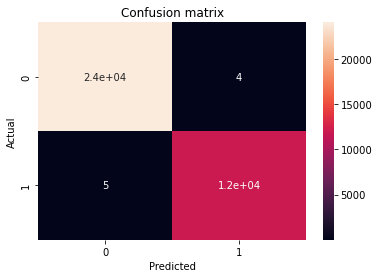

In [27]:
cm = confusion_matrix(y_test,y_pred)
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells
# labels, title and ticks
ax.set_xlabel('Predicted');ax.set_ylabel('Actual'); 
ax.set_title('Confusion matrix'); 